In [1]:
from tyxe_runfiles import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine

In [2]:
BASE_DIR = "./tests/sanity_check_mcmc"
PROFILE = "tyxe-test"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [3]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

====== Generating profile sin-(10,20)-1k ======


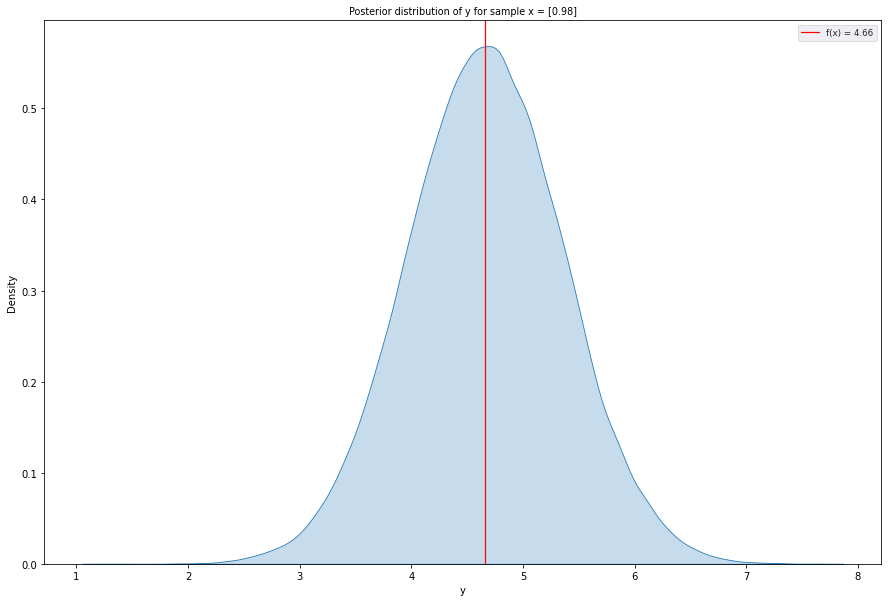

In [4]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [5]:
(x_train, y_train), _, (x_test, y_test), (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)

test-shape:  (1000, 2)
torch.Size([1000, 1]) torch.Size([1000, 1])


In [6]:
x_train.shape, y_train.shape

(torch.Size([10000, 1]), torch.Size([10000, 1]))

In [7]:
x_test[0], y_test[0]

(tensor([1.3441]), tensor([5.6975]))

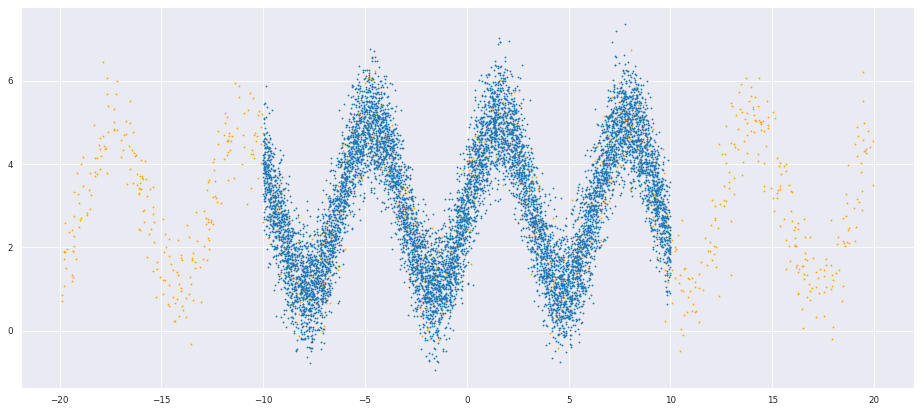

In [8]:
test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)


In [9]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    bnn, train_stats = train.train(config, dataset_config, f"{BASE_DIR}")

test-shape:  (1000, 2)
torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([512, 1]) torch.Size([512, 1])
Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): ReLU()
  (2): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (3): Linear(in_features=32, out_features=1, bias=True)
)
Using device: cpu
===== Training profile tyxe-test =====


Sample: 100%|██████████| 150/150 [13:07,  5.25s/it, step size=5.57e-04, acc. prob=0.877]

Training finished in 0:13:07.284940 seconds


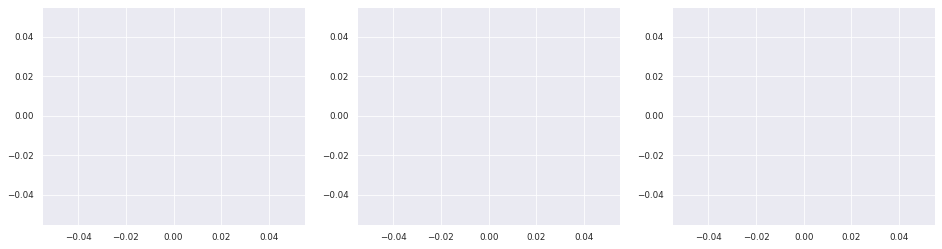

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].plot(train_stats["elbos"])
ax[1].plot(train_stats["rmse_epoch"])
ax[2].plot(train_stats["ll_epoch"])

In [11]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort], num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

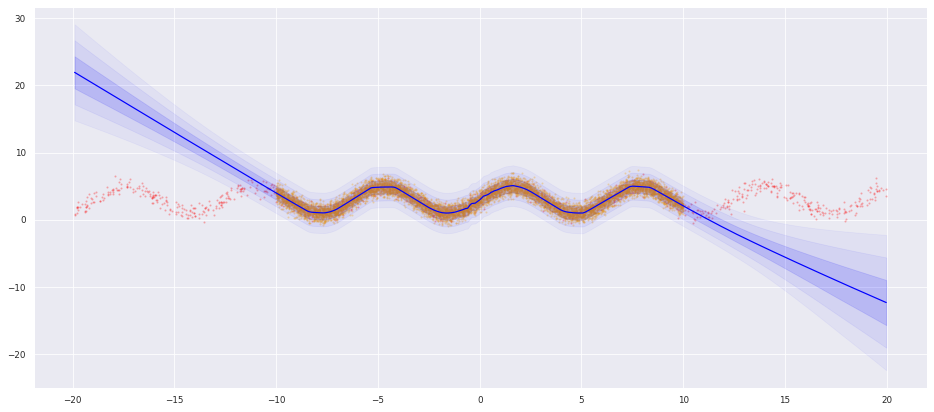

In [12]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

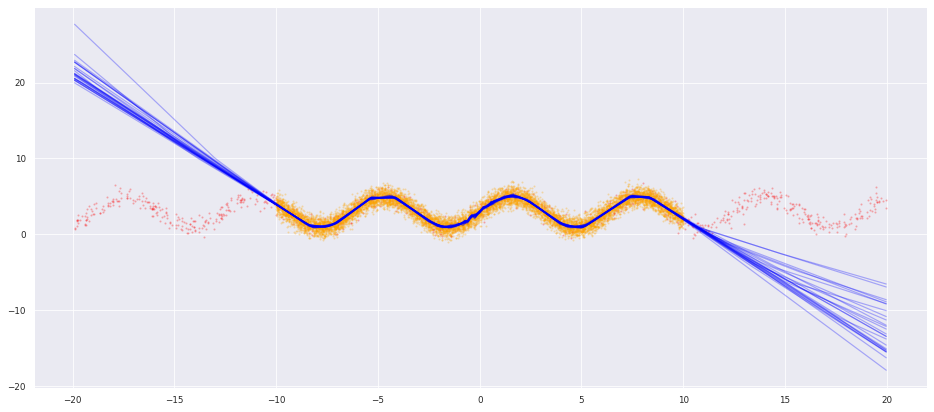

In [13]:
sampled_predictions = bnn.predict(x_test[test_sort], num_predictions=25, aggregate=False)
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)